In [1]:
import time
import os, scipy
import torch   
import scipy.sparse as sp 
import numpy as np  
import torch.nn.functional as F 
import pickle
import numpy.random as random
import matplotlib.pyplot as plt 
from math import *
from numpy import transpose,matrix,exp,conj
from numpy.linalg import inv 
from util_final import * 
import torch.nn as nn
from load_data import *
from PPGN import *

In [20]:
# parameters  
'''
dropout: whether has dropout operation
root: the root path
num_node: the number of the graph in stage I
dim_input: the dimension of the input at each node
num_labelper: the number of labeled data for each label, choose <=120
agg_func: the way of aggregate the hidden variables of its neighbors is to calculate mean
epochs: the number of epochs for training
b_sz: batch size
seed: random seed
learning_method: 'sup' denotes supervised
max_vali_f1: the initial maximum accuracy
hidden_emb_size: the size of the hidden variables in each layer
num_layers: the number of layers
faulttype: the type of the fault: 'pp' is phase to phase fault; 'sp3' is single phase fault; 'ppg' is phase to phase to ground; 'all' is the combination of all these three faults.
dataSet: the name of the dataset
device: cpu
lr: learning rate
weight_name: choose the adjacency matrix: 'A_short' is the proposed using shortest path; 'A_adam' is the normalized admittance matrix
k: denotes k_I, the nearest k neighbors are used to learn the hidden variables
measured_index: the measured nodes in power grids
dataC: datasets for training
A: the index of the neighbors of each node
prob_A: The adjacency matrix A 
modelname: the name of the saved model
savepath: the root path of saved model
savebest: the path of the best model
retrain: whether retrain the model 
'''
dropout = 0 
root = "./data/" 
num_node = 128   
dim_input = 6
num_labelper =  20
agg_func = "MEAN"
epochs =  300
b_sz = 32
global seed
seed = 842 
learn_method = 'sup' 
max_vali_f1 = 0  
hidden_emb_size = [32,32,32] 
num_layers = len(hidden_emb_size) 
faulttype = 'ppg'
dataSet = 'loc' 
device = "cpu"  
lr = 0.001
weight_name = 'A_short' 
k=3  
measured_index =[73, 94, 105, 118, 72, 79, 24, 41, 69, 90, 84, 78, 122, 49, 66, 104, 109, 10, 36, 31, 85]
A, prob_A = select_A_prob(k, 'A_short')  
modelname =   str(num_labelper) + '_' + faulttype +'_'  + '.pkl'
savepath = os.path.join('./', modelname ) 
savebest = os.path.join(  './trained' , 'sup_' +  str(num_labelper) + '_' + faulttype +  '_21.pkl') 
retrain =     False  

In [21]:
#load data   
name_train = 'train_set_allV.npz'
name_test = 'test_set_allV.npz'
if faulttype == 'all':
    features, labels, ind_train ,  ind_test,    neib_observ,ind_labels, ind_measured= load_all_types(name_train, name_test, num_labelper , measured_index,seed = seed )
else:
    features, labels, ind_train ,  ind_test,    neib_observ,ind_labels, ind_measured= load_data_single_observ( name_train, name_test, num_labelper ,seed, measured_index,  phase = faulttype )
with open(os.path.join(root, 'neib.pickle'), 'rb') as f:
    dic = pickle.load(f)
neib  = dic['neib']
random.seed( seed)
np.random.seed( seed)
torch.manual_seed( seed)
torch.cuda.manual_seed_all( seed)
dataC = dataCenter(name_train, name_test,num_labelper,seed, measured_index, faulttype) 
nodes_layers  = dic_nodes_neib(num_layers,A,prob_A ) 

In [22]:
################## PPGN in stage I ########################

In [23]:
graph_stageI = GraphSage(num_layers, dim_input,hidden_emb_size  ,   A, prob_A, dropout = dropout ,device = device,    agg_method= agg_func  )
graph_stageI.to(device) 
classification = Outlayer_fully( hidden_emb_size[-1],  num_node,  dropout = dropout ) 
classification.to(device)
models = [graph_stageI, classification]
params = []
for model in models:
    for param in model.parameters():
        if param.requires_grad:
            params.append(param)
optimizer = torch.optim.Adam(params, lr = lr, weight_decay = 5e-3)  
if retrain:
    models, optimizer, start_epoch = load_checkpoint(models, optimizer, savepath) 
    graph_stageI, classification  = models[0], models[1]

----------------------EPOCH 0-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 4.9154, Dealed Nodes [32/244] 
 Step [5/8], Loss: 4.7255, Dealed Nodes [192/244] 
Validation F1: 0.08823529411764706
Test F1: 0.08823529411764706
----------------------EPOCH 1-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 3.9442, Dealed Nodes [32/244] 
 Step [5/8], Loss: 3.7845, Dealed Nodes [192/244] 
Validation F1: 0.14705882352941177
Test F1: 0.14754901960784314
----------------------EPOCH 2-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 3.3821, Dealed Nodes [32/244] 
 Step [5/8], Loss: 3.3350, Dealed Nodes [192/244] 
Validation F1: 0.13725490196078433
----------------------EPOCH 3-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 2.9870, Dealed Nodes [32/244] 
 Step [5/8], Loss: 3.0258, Dealed Nodes [192/244] 
Validation F1: 0.1676470588235294
Test F1: 0.16715686274509803
----------------------

Epoch [9/10], Step [2/3], Loss: 0.8302, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.9359, Dealed Nodes [244/244]
Validation F1: 0.5553921568627451
Test F1: 0.5553921568627451
----------------------EPOCH 17-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 1.2629, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.9294, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 1.4088, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 1.0704, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.9207, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 1.0167, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.9688, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 1.1182, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.7741, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.7860, Dealed Nodes [24

Epoch [9/10], Step [2/3], Loss: 0.3451, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.5284, Dealed Nodes [244/244]
Validation F1: 0.6875
Test F1: 0.6904411764705882
----------------------EPOCH 34-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.7468, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.6825, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.4041, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.5646, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.3806, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.5133, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.4216, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.5347, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.4411, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.4567, Dealed Nodes [244/244]
Valid

Epoch [10/10], Step [2/3], Loss: 0.2014, Dealed Nodes [244/244]
Validation F1: 0.7583333333333333
Test F1: 0.7571078431372549
----------------------EPOCH 51-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.5974, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.4491, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.2900, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.2537, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.3598, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.2481, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.2634, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.2501, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.3421, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.2600, Dealed Nodes [244/244]
Validation F1: 0.7431372549019608
----------------------

 Step [5/8], Loss: 0.2281, Dealed Nodes [192/244] 
Validation F1: 0.7666666666666667
----------------------EPOCH 62-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.1377, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.2618, Dealed Nodes [192/244] 
Validation F1: 0.7507352941176471
----------------------EPOCH 63-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.1605, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.2144, Dealed Nodes [192/244] 
Validation F1: 0.7490196078431373
----------------------EPOCH 64-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.2588, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.3193, Dealed Nodes [192/244] 
Validation F1: 0.7517156862745098
----------------------EPOCH 65-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.1701, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.4327, Dealed Nodes [192/244] 
Validation F1: 0.7338235294117647
----------------------E

Epoch [5/10], Step [2/3], Loss: 0.2507, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.1230, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.1098, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.1326, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.1171, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.1174, Dealed Nodes [244/244]
Validation F1: 0.7973039215686275
Test F1: 0.7958333333333333
----------------------EPOCH 78-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1694, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.2231, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.1990, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.1365, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.1679, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.1844, Dealed Nodes [244

Epoch [6/10], Step [2/3], Loss: 0.1121, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.1269, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.1333, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.1234, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.1236, Dealed Nodes [244/244]
Validation F1: 0.7899509803921568
----------------------EPOCH 95-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1353, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.2371, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.2192, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.1751, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.0617, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.1630, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.0908, Dealed Nodes [244/244]
Epoch [8/10], Step [2/

Epoch [7/10], Step [2/3], Loss: 0.1387, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.0878, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.0739, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.0771, Dealed Nodes [244/244]
Validation F1: 0.8004901960784313
----------------------EPOCH 112-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.3716, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.2216, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.2526, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.0823, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.1207, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.0708, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.0842, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.1674, Dealed Nodes [244/244]
Epoch [9/10], Step [2

Validation F1: 0.7514705882352942
----------------------EPOCH 125-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.0950, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.1650, Dealed Nodes [192/244] 
Validation F1: 0.8002450980392157
----------------------EPOCH 126-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.0991, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.1536, Dealed Nodes [192/244] 
Validation F1: 0.7892156862745098
----------------------EPOCH 127-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.1600, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.1349, Dealed Nodes [192/244] 
Validation F1: 0.7745098039215687
----------------------EPOCH 128-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.0770, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.2348, Dealed Nodes [192/244] 
Validation F1: 0.7181372549019608
----------------------EPOCH 129-----------------------
Update the Whol

Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1442, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.0300, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.1436, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.0628, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.2486, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.0714, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.1033, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.1001, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.0632, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.1331, Dealed Nodes [244/244]
Validation F1: 0.8053921568627451
----------------------EPOCH 139-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.2098, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.1113, Dealed Nodes [244/244]
Ep

Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1742, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.1413, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.1181, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.0516, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.0952, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.0847, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.0778, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.0536, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.0546, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.0578, Dealed Nodes [244/244]
Validation F1: 0.8198529411764706
----------------------EPOCH 156-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1214, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.1565, Dealed Nodes [244/244]
Ep

Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1694, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.1082, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.0924, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.1086, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.0641, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.0609, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.1121, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.0567, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.0493, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.0775, Dealed Nodes [244/244]
Validation F1: 0.8257352941176471
Test F1: 0.8196078431372549
----------------------EPOCH 173-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1625, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.139

Validation F1: 0.7982843137254902
----------------------EPOCH 187-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.1337, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.1595, Dealed Nodes [192/244] 
Validation F1: 0.7200980392156863
----------------------EPOCH 188-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.4611, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.1746, Dealed Nodes [192/244] 
Validation F1: 0.7014705882352941
----------------------EPOCH 189-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.2716, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.2908, Dealed Nodes [192/244] 
Validation F1: 0.8088235294117648
----------------------EPOCH 190-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1342, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.4294, Dea

Epoch [10/10], Step [2/3], Loss: 0.0697, Dealed Nodes [244/244]
Validation F1: 0.8102941176470588
----------------------EPOCH 199-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1097, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.0809, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.0704, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.0563, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.0541, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.0448, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.0459, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.0387, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.0392, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.0419, Dealed Nodes [244/244]
Validation F1: 0.8169117647058823
----------------------EPOCH 200------------------

Validation F1: 0.8252450980392156
----------------------EPOCH 216-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1016, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.0842, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.0410, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.0680, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.0760, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.0966, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.0422, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.0721, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.0682, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.0290, Dealed Nodes [244/244]
Validation F1: 0.8159313725490197
----------------------EPOCH 217-----------------------
Update only the fully connect layers
Training Classificati

Epoch [10/10], Step [2/3], Loss: 0.0500, Dealed Nodes [244/244]
Validation F1: 0.8411764705882353
Test F1: 0.8316176470588237
----------------------EPOCH 233-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1194, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.1519, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.0474, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.1049, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.0658, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.0701, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.0750, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.0594, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.0755, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.0287, Dealed Nodes [244/244]
Validation F1: 0.8200980392156862
---------------------

 Step [5/8], Loss: 0.0694, Dealed Nodes [192/244] 
Validation F1: 0.7936274509803921
----------------------EPOCH 250-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.0903, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.1604, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.1011, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.1573, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.0922, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.0968, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.1107, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.0373, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.1031, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.0794, Dealed Nodes [244/244]
Validation F1: 0.8227941176470588
----------------------EPOCH 251-----------------------
Update 

Epoch [6/10], Step [2/3], Loss: 0.0930, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.0164, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.0640, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.0562, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.0467, Dealed Nodes [244/244]
Validation F1: 0.8404411764705882
----------------------EPOCH 260-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.0176, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.2701, Dealed Nodes [192/244] 
Validation F1: 0.8181372549019608
----------------------EPOCH 261-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.0827, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.0667, Dealed Nodes [192/244] 
Validation F1: 0.8296568627450981
----------------------EPOCH 262-----------------------
Update the Whole Graph in stage I
 Step [0/8], Loss: 0.0133, Dealed Nodes [32/244] 
 Step [5/8], Loss: 0.0604, Dealed Nodes [192/244] 
Validation F

Epoch [6/10], Step [2/3], Loss: 0.0695, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.0351, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.0296, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.0524, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.0194, Dealed Nodes [244/244]
Validation F1: 0.8450980392156864
Test F1: 0.846078431372549
----------------------EPOCH 277-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.1201, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.1156, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.1196, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.1107, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.0492, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.0820, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.0520, Dealed Nodes [244

Epoch [8/10], Step [2/3], Loss: 0.0334, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.0474, Dealed Nodes [244/244]
Epoch [10/10], Step [2/3], Loss: 0.0648, Dealed Nodes [244/244]
Validation F1: 0.8387254901960784
----------------------EPOCH 294-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [2/3], Loss: 0.0904, Dealed Nodes [244/244]
Epoch [2/10], Step [2/3], Loss: 0.0944, Dealed Nodes [244/244]
Epoch [3/10], Step [2/3], Loss: 0.0407, Dealed Nodes [244/244]
Epoch [4/10], Step [2/3], Loss: 0.0465, Dealed Nodes [244/244]
Epoch [5/10], Step [2/3], Loss: 0.0590, Dealed Nodes [244/244]
Epoch [6/10], Step [2/3], Loss: 0.0570, Dealed Nodes [244/244]
Epoch [7/10], Step [2/3], Loss: 0.0544, Dealed Nodes [244/244]
Epoch [8/10], Step [2/3], Loss: 0.0558, Dealed Nodes [244/244]
Epoch [9/10], Step [2/3], Loss: 0.0341, Dealed Nodes [244/244]
Epoch [10/10], Step [

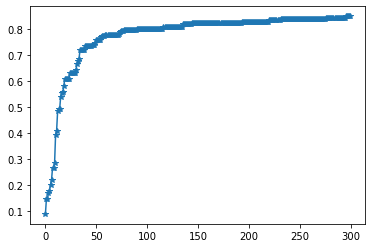

In [6]:
# training
f1_list = []
test_acc = 0 
T1 = 10
T2 = 10
epochs =300
r_sup = [range(i,i+T1) for i in range(0, epochs, int(T1 + T2))]
r_unsup = [range( i , i   + T2) for i in range(T1, epochs, int(T1 + T2))] 
r_unsup = [i for sub in r_unsup for i in sub]
r_sup = [i for sub in r_sup for i in sub]
for epoch in range(epochs ):
    print('----------------------EPOCH %d-----------------------' % epoch) 
    if epoch in r_sup:
        learn_method = 'sup'
        print('Update the Whole Graph in stage I')
        graph_stageI, classification, optimizer = apply_model(  optimizer, nodes_layers ,   dataC , 'loc', graph_stageI, classification,     b_sz,  device  , learn_method )
        max_vali_f1, test_f1 = evaluate(nodes_layers , dataC , dataSet, graph_stageI, classification, device,  max_vali_f1,    epoch)
    elif epoch in r_unsup:  
        print('Update only the fully connect layers')
        classification, max_vali_f1, test_f1 =train_classification( nodes_layers ,dataC , graph_stageI, classification, dataSet, device, max_vali_f1  )
    f1_list.append(max_vali_f1)
    if test_f1 > test_acc:
        test_acc = test_f1    
        state = {'epoch': epoch + 1, 'state_dict': [graph_stageI.state_dict(), classification.state_dict()],
             'optimizer': optimizer.state_dict() }
        torch.save(state, savepath) 
plt.plot(f1_list, '*-')      
print('max valid acc', max(f1_list))
print('test acc', test_acc)

In [24]:
# Test the saved model in stage I
models, optimizer, start_epoch = load_checkpoint(models, optimizer , savebest)
graph_stageI, classification = models[0], models[1]
labels_neib = one_hot_neib(labels, neib )
models = [graph_stageI, classification]
params = []
for model in models:
    for param in model.parameters():
        if param.requires_grad:
            param.requires_grad = False
            params.append(param)

embs = graph_stageI( nodes_layers ,features)
logists =  classification(embs)
predicts = torch.max(logists, 1)[1]
labels_test = labels[ind_test] 
labels_neib_test = labels_neib[ind_test]
assert len(labels[ind_test] ) == len(predicts[ind_test]  ) 
test_f1 = f1_score(labels[ind_test] , predicts[ind_test].cpu().data, average="macro")
acc = accuracy_score(labels_test, predicts[ind_test].cpu().data)
acc_neib = hop_acc(labels_neib_test, predicts[ind_test].cpu().data)
print("Test F1:%.4f,  Acc:%.4f, Acc 1 hop: %.4f " %(test_f1, acc, acc_neib))  

=> loading checkpoint './00_saved_final/sup_20_ppg_21.pkl'
=> loaded checkpoint './00_saved_final/sup_20_ppg_21.pkl' (epoch 489)
Test F1:0.9120,  Acc:0.9196, Acc 1 hop: 0.9461 


In [8]:
################## Graph in stage II ########################

In [25]:
# stage II parameters
'''
K_II: the top K_II similar neighbors have nonzero values in Adjacency B
Adj: this is the adjacency matrix B
feature_X: input of the graph in stage II
weight_decay: the coefficient of the regularization in the loss function
batch_size: batch size
hidden: the dimensions of the hidden variables in each layer
dropout = 0: not add drop out
retrain2: retrain or not
model_name: name of the saved model in stage II
savepath2: the path of the saved model in stage II 
best_acc: the best accruacy
'''
K_II = 130
Adj = constructW_stageI(embs , logists  ,A_labels(A ), K_II )
features_X = torch.reshape(features, [features.shape[0],features.shape[1] *features.shape[2] ])
seed = 42; epochs =300
lr = 0.001
weight_decay = 5e-5
batch_size = 32
hidden = [128*3,128*3, 128*3 ]
dropout =0    
retrain2= False
model_name =  'Whole_' + faulttype + '_' + str(num_labelper) + '.pkl' 
savepath2 = os.path.join('./', model_name)  
best_acc = 0

In [26]:
model2 = GCN(nfeat=features_X.shape[1],
            nhid= hidden,
            nclass=119, 
            dropout= dropout)
optimizer2 = torch.optim.Adam(model2.parameters(),
                       lr= lr, weight_decay= weight_decay)  
if retrain2:
    model2.load_state_dict(torch.load(savepath2)['state_dict'] )   
    optimizer2.load_state_dict(torch.load(savepath2)['optimizer'] )   

In [27]:
# Train model  
t_total = time.time()
acc_epoch = []
start = time.time()
for epoch in range(epochs):  
    acc_train = train( epoch, model2,optimizer2,  features_X    , labels   , Adj, ind_train,  ind_train, batch_size)
    acc_test, acc_hop = test(model2, features_X , labels ,A_labels(A ),  Adj, ind_test)
    acc_epoch.append(acc_test.numpy())
    if acc_test.numpy() > best_acc:
        best_acc = acc_test.numpy() 
        state = {'epoch': epoch + 1, 'state_dict': model2.state_dict() ,
             'optimizer': optimizer2.state_dict() }
        torch.save(state, savepath2)
print("Optimization Finished!") 
print('The max acc is %.4f' %np.max(acc_epoch))  
print('The test max acc is %.4f' %np.max(acc_epoch))
print('The test argmax acc is %2d' %np.argmax(acc_epoch)) 

Epoch: 0001 loss_train: 4.7928 acc_train: 0.0000 loss_val: 4.7180 acc_val: 0.0650 time: 0.8105s
Test set results: loss= 4.7176 accuracy= 0.0627 1-hop accuracy = 0.0939
Epoch: 0002 loss_train: 4.7180 acc_train: 0.0650 loss_val: 4.6502 acc_val: 0.0922 time: 0.8128s
Test set results: loss= 4.6493 accuracy= 0.0951 1-hop accuracy = 0.1674
Epoch: 0003 loss_train: 4.6502 acc_train: 0.0922 loss_val: 4.5803 acc_val: 0.1370 time: 0.8405s
Test set results: loss= 4.5791 accuracy= 0.1370 1-hop accuracy = 0.1951
Epoch: 0004 loss_train: 4.5803 acc_train: 0.1370 loss_val: 4.5027 acc_val: 0.1444 time: 0.8021s
Test set results: loss= 4.5010 accuracy= 0.1446 1-hop accuracy = 0.2027
Epoch: 0005 loss_train: 4.5027 acc_train: 0.1444 loss_val: 4.4141 acc_val: 0.1441 time: 0.8672s
Test set results: loss= 4.4119 accuracy= 0.1475 1-hop accuracy = 0.2069
Epoch: 0006 loss_train: 4.4141 acc_train: 0.1441 loss_val: 4.3135 acc_val: 0.1466 time: 0.8579s
Test set results: loss= 4.3107 accuracy= 0.1498 1-hop accuracy =

Epoch: 0050 loss_train: 1.3672 acc_train: 0.8382 loss_val: 1.3254 acc_val: 0.8576 time: 0.8008s
Test set results: loss= 1.3545 accuracy= 0.8498 1-hop accuracy = 0.9336
Epoch: 0051 loss_train: 1.3254 acc_train: 0.8576 loss_val: 1.2838 acc_val: 0.8752 time: 0.8087s
Test set results: loss= 1.3138 accuracy= 0.8654 1-hop accuracy = 0.9490
Epoch: 0052 loss_train: 1.2838 acc_train: 0.8752 loss_val: 1.2435 acc_val: 0.8904 time: 0.8089s
Test set results: loss= 1.2741 accuracy= 0.8814 1-hop accuracy = 0.9502
Epoch: 0053 loss_train: 1.2435 acc_train: 0.8904 loss_val: 1.2046 acc_val: 0.8787 time: 0.7942s
Test set results: loss= 1.2359 accuracy= 0.8684 1-hop accuracy = 0.9515
Epoch: 0054 loss_train: 1.2046 acc_train: 0.8787 loss_val: 1.1663 acc_val: 0.8929 time: 0.7960s
Test set results: loss= 1.1986 accuracy= 0.8848 1-hop accuracy = 0.9654
Epoch: 0055 loss_train: 1.1663 acc_train: 0.8929 loss_val: 1.1295 acc_val: 0.8924 time: 0.7859s
Test set results: loss= 1.1628 accuracy= 0.8848 1-hop accuracy =

Epoch: 0099 loss_train: 0.3830 acc_train: 0.9316 loss_val: 0.3775 acc_val: 0.9319 time: 0.8092s
Test set results: loss= 0.4364 accuracy= 0.9201 1-hop accuracy = 0.9882
Epoch: 0100 loss_train: 0.3775 acc_train: 0.9319 loss_val: 0.3722 acc_val: 0.9324 time: 0.8412s
Test set results: loss= 0.4318 accuracy= 0.9201 1-hop accuracy = 0.9882
Epoch: 0101 loss_train: 0.3722 acc_train: 0.9324 loss_val: 0.3671 acc_val: 0.9324 time: 0.8489s
Test set results: loss= 0.4271 accuracy= 0.9201 1-hop accuracy = 0.9882
Epoch: 0102 loss_train: 0.3671 acc_train: 0.9324 loss_val: 0.3622 acc_val: 0.9324 time: 0.8451s
Test set results: loss= 0.4225 accuracy= 0.9199 1-hop accuracy = 0.9882
Epoch: 0103 loss_train: 0.3622 acc_train: 0.9324 loss_val: 0.3573 acc_val: 0.9321 time: 0.8475s
Test set results: loss= 0.4181 accuracy= 0.9199 1-hop accuracy = 0.9882
Epoch: 0104 loss_train: 0.3573 acc_train: 0.9321 loss_val: 0.3527 acc_val: 0.9326 time: 0.8400s
Test set results: loss= 0.4141 accuracy= 0.9199 1-hop accuracy =

Epoch: 0148 loss_train: 0.2450 acc_train: 0.9350 loss_val: 0.2437 acc_val: 0.9360 time: 0.8628s
Test set results: loss= 0.3097 accuracy= 0.9230 1-hop accuracy = 0.9919
Epoch: 0149 loss_train: 0.2437 acc_train: 0.9360 loss_val: 0.2425 acc_val: 0.9355 time: 0.8600s
Test set results: loss= 0.3087 accuracy= 0.9238 1-hop accuracy = 0.9919
Epoch: 0150 loss_train: 0.2425 acc_train: 0.9355 loss_val: 0.2414 acc_val: 0.9355 time: 0.8367s
Test set results: loss= 0.3080 accuracy= 0.9238 1-hop accuracy = 0.9919
Epoch: 0151 loss_train: 0.2414 acc_train: 0.9355 loss_val: 0.2403 acc_val: 0.9368 time: 0.8810s
Test set results: loss= 0.3069 accuracy= 0.9235 1-hop accuracy = 0.9919
Epoch: 0152 loss_train: 0.2403 acc_train: 0.9368 loss_val: 0.2393 acc_val: 0.9350 time: 0.8766s
Test set results: loss= 0.3067 accuracy= 0.9243 1-hop accuracy = 0.9919
Epoch: 0153 loss_train: 0.2393 acc_train: 0.9350 loss_val: 0.2384 acc_val: 0.9360 time: 0.8485s
Test set results: loss= 0.3059 accuracy= 0.9228 1-hop accuracy =

Epoch: 0197 loss_train: 0.2115 acc_train: 0.9390 loss_val: 0.2112 acc_val: 0.9368 time: 0.8625s
Test set results: loss= 0.2869 accuracy= 0.9272 1-hop accuracy = 0.9922
Epoch: 0198 loss_train: 0.2112 acc_train: 0.9368 loss_val: 0.2109 acc_val: 0.9385 time: 0.9059s
Test set results: loss= 0.2869 accuracy= 0.9275 1-hop accuracy = 0.9922
Epoch: 0199 loss_train: 0.2109 acc_train: 0.9385 loss_val: 0.2105 acc_val: 0.9370 time: 0.8892s
Test set results: loss= 0.2867 accuracy= 0.9275 1-hop accuracy = 0.9922
Epoch: 0200 loss_train: 0.2105 acc_train: 0.9370 loss_val: 0.2101 acc_val: 0.9390 time: 0.8908s
Test set results: loss= 0.2863 accuracy= 0.9275 1-hop accuracy = 0.9922
Epoch: 0201 loss_train: 0.2101 acc_train: 0.9390 loss_val: 0.2098 acc_val: 0.9365 time: 0.8891s
Test set results: loss= 0.2861 accuracy= 0.9267 1-hop accuracy = 0.9922
Epoch: 0202 loss_train: 0.2098 acc_train: 0.9365 loss_val: 0.2094 acc_val: 0.9392 time: 0.8832s
Test set results: loss= 0.2860 accuracy= 0.9277 1-hop accuracy =

Epoch: 0246 loss_train: 0.1988 acc_train: 0.9395 loss_val: 0.1986 acc_val: 0.9390 time: 0.8972s
Test set results: loss= 0.2807 accuracy= 0.9275 1-hop accuracy = 0.9924
Epoch: 0247 loss_train: 0.1986 acc_train: 0.9390 loss_val: 0.1985 acc_val: 0.9400 time: 0.9213s
Test set results: loss= 0.2802 accuracy= 0.9275 1-hop accuracy = 0.9924
Epoch: 0248 loss_train: 0.1985 acc_train: 0.9400 loss_val: 0.1983 acc_val: 0.9392 time: 0.9077s
Test set results: loss= 0.2807 accuracy= 0.9275 1-hop accuracy = 0.9924
Epoch: 0249 loss_train: 0.1983 acc_train: 0.9392 loss_val: 0.1981 acc_val: 0.9387 time: 0.9246s
Test set results: loss= 0.2801 accuracy= 0.9275 1-hop accuracy = 0.9924
Epoch: 0250 loss_train: 0.1981 acc_train: 0.9387 loss_val: 0.1979 acc_val: 0.9397 time: 0.9031s
Test set results: loss= 0.2804 accuracy= 0.9289 1-hop accuracy = 0.9924
Epoch: 0251 loss_train: 0.1979 acc_train: 0.9397 loss_val: 0.1977 acc_val: 0.9390 time: 0.9395s
Test set results: loss= 0.2798 accuracy= 0.9282 1-hop accuracy =

Epoch: 0295 loss_train: 0.1917 acc_train: 0.9392 loss_val: 0.1916 acc_val: 0.9409 time: 0.9058s
Test set results: loss= 0.2791 accuracy= 0.9297 1-hop accuracy = 0.9924
Epoch: 0296 loss_train: 0.1916 acc_train: 0.9409 loss_val: 0.1914 acc_val: 0.9395 time: 0.8944s
Test set results: loss= 0.2788 accuracy= 0.9294 1-hop accuracy = 0.9924
Epoch: 0297 loss_train: 0.1914 acc_train: 0.9395 loss_val: 0.1914 acc_val: 0.9407 time: 0.8881s
Test set results: loss= 0.2788 accuracy= 0.9279 1-hop accuracy = 0.9924
Epoch: 0298 loss_train: 0.1914 acc_train: 0.9407 loss_val: 0.1915 acc_val: 0.9385 time: 0.8842s
Test set results: loss= 0.2792 accuracy= 0.9277 1-hop accuracy = 0.9924
Epoch: 0299 loss_train: 0.1915 acc_train: 0.9385 loss_val: 0.1915 acc_val: 0.9409 time: 0.8841s
Test set results: loss= 0.2791 accuracy= 0.9275 1-hop accuracy = 0.9924
Epoch: 0300 loss_train: 0.1915 acc_train: 0.9409 loss_val: 0.1916 acc_val: 0.9392 time: 0.8738s
Test set results: loss= 0.2794 accuracy= 0.9272 1-hop accuracy =